# Promotional Offer Response Prediction

This notebook is the submission code that will help us achieve our main goal: train our classification model on AWS SageMaker and then deploy it to an endpoint, so we can make inference on new data.

Additionally, since we are seeking the best possible performance, we will take advantage of some functionalities, such as hyperparameter tuning, debugging and profiling.

At the end of this notebook, we will have deployed a fine-tuned classification model that predicts whether a customer will respond to a given promotional offer.

## 1. Libraries

Useful packages that will allow us to orchestrate the whole end-to-end process.

In [1]:
import os
import json
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, f1_score, 
    roc_auc_score, cohen_kappa_score, roc_curve, precision_recall_curve
)
import warnings
warnings.filterwarnings("ignore")

import boto3
import sagemaker
from sagemaker.sklearn import SKLearn
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, IntegerParameter, HyperparameterTuner
from sagemaker.sklearn import SKLearnModel
from sagemaker.predictor import Predictor
from sagemaker.serializers import JSONSerializer, CSVSerializer
from sagemaker.deserializers import JSONDeserializer

Some basic definitions that help us get permission to execute training jobs and to interact with other AWS services, such as S3 Buckets in order to retrieve and upload data.

In [2]:
session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = session.boto_region_name

## 2. Dataset

In order to develop our model, we will use data that is available for the **Starbucks Project**, which was made available during the test period. Basically, we have three JSON files:

1. **profile.json**: Rewards program users;
2. **portfolio.json**: Offers sent during 30-day test period;
3. **transcript.json**: Event log.

All of them were properly uploaded to an S3 Bucket.

In [3]:
raw_data_path = "./raw-data"
bucket_name = "starbucks-project"

try:
    os.mkdir(raw_data_path)
except:
    pass

s3 = boto3.resource('s3')
my_bucket = s3.Bucket(bucket_name)

for obj in my_bucket.objects.all():
    path, file = os.path.split(obj.key)
    if file and path=="raw-data":
        my_bucket.download_file(obj.key, os.path.join(raw_data_path, file))

First, we need to read our raw data.

In [4]:
df_portfolio = pd.read_json(os.path.join(raw_data_path, "portfolio.json"), lines=True)
df_profile = pd.read_json(os.path.join(raw_data_path, "profile.json"), lines=True)
df_transcript = pd.read_json(os.path.join(raw_data_path, "transcript.json"), lines=True)

Below we define some methods that will help us build the dataset that is actually going to be used to train and evaluate our model. Moreover, feature engineering is performed, so that we are allowed to achieve a better overall performance.

In [5]:
def build_offer_received_dataset(df_transcript: pd.DataFrame) -> pd.DataFrame:
    """
    Function that obtains the label to our problem according to a given user reacting or not to a promotional offer.

        Args: 
            df_transcript (pandas.DataFrame): event log dataset

        Returns: 
           pandas.DataFrame with every sent offer to a given customer and the final result (responded or not responded)
    """
    
    # Retrieving all offers received by customer
    offers_received = df_transcript.loc[df_transcript.event == "offer received", :]
    offers_received.loc[:, "offer"] = offers_received.loc[:, "value"].apply(lambda x: x["offer id"])
    offers_received = offers_received.loc[:, ["person", "offer", "time_in_days"]]
    offers_received = pd.merge(offers_received, df_portfolio.loc[:, ["id", "duration", "difficulty"]],
                               left_on="offer", right_on="id", how="inner")
    
    # Obtaining offers viewed while offer was active 
    offers_viewed = df_transcript.loc[df_transcript.event == "offer viewed", :]
    offers_viewed.loc[:, "offer"] = offers_viewed.loc[:, "value"].apply(lambda x: x["offer id"])
    offers_viewed = pd.merge(offers_received, offers_viewed, on=["person", "offer"], 
                             how="outer", suffixes=["_received", "_viewed"])
    offers_viewed = offers_viewed.loc[
        (offers_viewed.time_in_days_viewed > offers_viewed.time_in_days_received) &
        (offers_viewed.time_in_days_viewed - offers_viewed.time_in_days_received <= offers_viewed.duration), :]
    cols = ["person", "offer", "duration", "difficulty", "time_in_days_received", "time_in_days_viewed"]
    offers_viewed = offers_viewed.loc[:, cols]
    
    # Completed INFORMATIONAL offers (difficulty 0)
    transactioned = df_transcript.loc[df_transcript.event == "transaction", ["person", "time_in_days"]]
    transactioned = pd.merge(offers_viewed, transactioned, on=["person"], 
                             how="outer", suffixes=["_viewed", "_transactioned"])
    transactioned = (transactioned.loc[
        (transactioned.time_in_days > transactioned.time_in_days_viewed) &
        (transactioned.time_in_days - transactioned.time_in_days_received <= transactioned.time_in_days_received) &
        (transactioned.difficulty == 0), ["person", "offer", "time_in_days_received", "time_in_days"]]
                                  .groupby(["person", "offer", "time_in_days_received"])
                                  .first()
                                  .reset_index()
                                  .iloc[:, :-1]
    )
    
    # Completed offers for all other cases
    offers_completed = df_transcript.loc[df_transcript.event == "offer completed", :]
    offers_completed.loc[:, "offer"] = offers_completed.loc[:, "value"].apply(lambda x: x["offer_id"])
    offers_completed = pd.merge(offers_viewed, offers_completed, on=["person", "offer"], 
                                how="outer", suffixes=["_viewed", "_completed"])
    offers_completed = offers_completed.loc[
        (offers_completed.time_in_days > offers_completed.time_in_days_viewed) &
        (offers_completed.time_in_days - offers_completed.time_in_days_received <= offers_completed.duration) &
        (offers_completed.difficulty != 0), :]
    cols = ["person", "offer", "duration", "difficulty", "time_in_days_received", 
            "time_in_days_viewed", "time_in_days"]
    offers_completed = offers_completed.loc[:, cols]
    
    # Concatenating all completed offers
    offers_successful = pd.concat(
        [
            offers_completed.loc[:, ["person", "offer", "time_in_days_received"]],
            transactioned.loc[:, ["person", "offer", "time_in_days_received"]]
        ],
        axis=0
    )
    offers_successful = offers_successful.drop_duplicates()
    offers_successful.loc[:, "responded_customer"] = 1
    
    # Final base dataset
    offers_received = offers_received.rename(columns={"time_in_days": "time_in_days_received"})
    df = pd.merge(
        offers_received.loc[:, ["person", "offer", "time_in_days_received"]],
        offers_successful,
        how="left",
        on=["person", "offer", "time_in_days_received"]
    )
    df = (df.sort_values(by=["person", "offer", "time_in_days_received"])
            .fillna(0)
         )
    df.loc[:, "responded_customer"] = df.loc[:, "responded_customer"].astype(int)
    
    return df


def feature_engineering(base_df: pd.DataFrame, df_profile: pd.DataFrame,
                        df_portfolio: pd.DataFrame, df_transcript: pd.DataFrame) -> pd.DataFrame:
    """
    Function that performs feature engineering and hence enriches the base dataset with our labbels

        Args:
            base_df (pandas.DataFrame): base dataframe with every sent offer to a given customer and the final result (responded or not responded)
            df_profile (pandas.DataFrame): rewards program users
            df_portfolio (pandas.DataFrame): offers available during 30-day test period
            df_transcript (pandas.DataFrame): event log dataset

        Returns: 
           pandas.DataFrame with features and target label that will actually be used to train the model
    """
    
    # Adding customer-specific features
    df = pd.merge(left=base_df, right=df_profile, how="inner", left_on="person", right_on="id")
    df = df.drop(columns=["id"])
    df.loc[:, "gender"] = df.loc[:, "gender"].astype("category")
    df.loc[:, "membership_duration"] = (
        (df.loc[:, "became_member_on"].max() - df.loc[:, "became_member_on"]).dt.days
    )
    df = df.drop(columns=["became_member_on"])
    
    # Adding offer-specific features
    df = pd.merge(left=df, right=df_portfolio, how="inner", left_on="offer", right_on="id")
    df = df.drop(columns=["id"])
    df.loc[:, "offer_type"] = df.loc[:, "offer_type"].astype("category")
    channels = df.channels.explode().unique()
    for channel in channels:
        df.loc[:, channel] = df.loc[:, "channels"].apply(lambda x: channel in x).astype(int)
    df = df.drop(columns=["channels"])
    
    # Adding transactional features
    transactions = df_transcript.loc[df_transcript.event == "transaction", ["person", "value", "time_in_days"]]
    transactions.loc[:, "amount"] = transactions.loc[:, "value"].apply(lambda x: x["amount"])
    transactions = transactions.drop(columns=["value"])
    
    key_columns = ["person", "offer", "time_in_days_received"]
    df_keys = df.loc[:, key_columns]
    transactional_feats = pd.merge(df_keys, transactions, on=["person"], how="left")
    transactional_feats = (
        transactional_feats.loc[(transactional_feats.time_in_days < transactional_feats.time_in_days_received), :]
    )
    transactional_feats = (
        transactional_feats.groupby(key_columns)
                           .agg({"amount": "mean", "time_in_days": "count"})
                           .reset_index()
                           .rename(columns={"amount": "average_purchase", "time_in_days": "frequency"})
    )
    df = pd.merge(df, transactional_feats, how="left", on=key_columns)
    df.loc[:, "average_purchase"] = df.loc[:, "average_purchase"].fillna(0)
    df.loc[:, "frequency"] = df.loc[:, "frequency"].fillna(0)
    
    return df


def build_final_dataset(df_profile: pd.DataFrame, df_portfolio: pd.DataFrame, 
                        df_transcript: pd.DataFrame) -> pd.DataFrame:
    """
    Function that process the raw data into data that will feed the model

        Args:
            df_profile (pandas.DataFrame): rewards program users
            df_portfolio (pandas.DataFrame): offers available during 30-day test period
            df_transcript (pandas.DataFrame): event log dataset

        Returns: 
           pandas.DataFrame with features and target label that will actually be used to train the model
    """
    
    # Initial Preprocessing
    df_profile.loc[:, "became_member_on"] = pd.to_datetime(
                                                df_profile.loc[:, "became_member_on"]
                                                          .astype(str)
                                                          .apply(lambda x: f"{x[-2:]}-{x[4:-2]}-{x[:4]}")
                                        )
    df_profile.loc[:, "age"] = df_profile.loc[:, "age"].apply(lambda x: np.nan if x==118 else x)
    df_transcript.loc[:, "time_in_days"] = df_transcript.loc[:, "time"] / 24
    
    # Final Tranformation
    base_df = build_offer_received_dataset(df_transcript)
    df = feature_engineering(base_df, df_profile, df_portfolio, df_transcript)
    return df

Obtaining preprocessed and transformed data:

In [6]:
df = build_final_dataset(df_profile, df_portfolio, df_transcript)
df.head()

,person,offer,time_in_days_received,responded_customer,gender,age,income,membership_duration,reward,difficulty,duration,offer_type,web,email,mobile,social,average_purchase,frequency
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0,M,33.0,72000.0,595,2,10,7,discount,1,1,1,0,14.600000,4.0
1,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,17.0,0,F,19.0,65000.0,820,2,10,7,discount,1,1,1,0,4.666923,13.0
2,00426fe3ffde4c6b9cb9ad6d077a13ea,2906b810c7d4411798c6938adc9daaa5,24.0,0,F,19.0,65000.0,820,2,10,7,discount,1,1,1,0,4.469286,14.0
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,17.0,0,M,56.0,47000.0,451,2,10,7,discount,1,1,1,0,4.855000,2.0
4,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,21.0,0,NaN,NaN,NaN,1007,2,10,7,discount,1,1,1,0,6.803333,3.0


The last step before we dive deep into statistical analyses of the features and the model development itself is splitting data into training and test sets.

We should be careful to **prevent data leakage**, since the same offer could be sent to a customer more than once. So, the same data point (or at least very similar) could appear in both sets, leading to an overestimate of final performance.

Therefore, we will take into account the pair offer-person when splitting. In order to do that, we will combine the two id columns and then perform **hashing**. By bucketizing the hashing result, we will be able to split the datasets accordingly.

In [7]:
def train_validation_test_split(df: pd.DataFrame, hash_buckets: int = 10,
                                val_size: float = 0.2, test_size: float = 0.2):
    """
    Function that splits the dataset into three sets - training, validation and testing - by hashing the pair user-offer.

        Args:
            df (pandas.DataFrame): final dataframe containing features and target label
            hash_buckets (int): number of buckets to hash the data
            val_size (float): fraction of the data that will be used for validation
            test_size (float): fraction of the data that will be used for testing

        Returns: 
           Tuple of pandas.DataFrame containing all three sets: training, validation and testing
    """
    df.loc[:, "hash_id"] = df.apply(lambda x: hash(x["person"]+x["offer"]) % hash_buckets, axis=1)
    
    test_idx = int(test_size * hash_buckets)
    val_idx = test_idx + int(val_size * hash_buckets)

    df_test = df.loc[df.hash_id < test_idx, :]
    df_val = df.loc[(df.hash_id < val_idx) & (df.hash_id >= test_idx), :]
    df_train = df.loc[df.hash_id >= val_idx, :]
    
    return (df_train, df_val, df_test)

In [8]:
df_train, df_val, df_test = train_validation_test_split(
    df=df,
    hash_buckets=10,
    val_size=0.2,
    test_size=0.2
)

Sanity Check:

In [9]:
train_size = np.round(df_train.shape[0] / df.shape[0], 2)
val_size = np.round(df_val.shape[0] / df.shape[0], 2)
test_size = np.round(df_test.shape[0] / df.shape[0], 2)

print(f"Train Size: {train_size}")
print(f"Val Size: {val_size}")
print(f"Test Size: {test_size}")

Train Size: 0.6
Val Size: 0.2
Test Size: 0.2


Finally, processed data is uploaded to the S3 Bucket accordingly, so that our Training Job is able to access it later on.

In [10]:
transformed_data_path = "./data"

try:
    os.mkdir(transformed_data_path)
    os.mkdir(os.path.join(transformed_data_path, "train"))
    os.mkdir(os.path.join(transformed_data_path, "test"))
except:
    pass

df_train.to_csv(os.path.join(transformed_data_path, "train", "train"), index=False)
df_train.to_csv(os.path.join(transformed_data_path, "train", "validation"), index=False)
df_train.to_csv(os.path.join(transformed_data_path, "test", "test"), index=False)

In [11]:
s3_data_path = session.upload_data(transformed_data_path, bucket=bucket_name)

## 3. Hyperparameter Tuning

Since we aim to obtain the best performing model, it is very important that we adjust the hyperparameters accordingly. Therefore, we are going to launch a hyperparameter tuning job so we can find the best ones.

In this context, we chose the following hyperparameters:

### 3.1. Preprocessing

* `Resampling ratio`: Since we perform oversampling with SMOTE, this is a hyperparameter that we can adjust to increase training performance. This is a **continuous value**;
* `Numerical imputation method`: This is a **categorical value** that need to be selected to impute missing numerical data: _mean_ x _median_;
* `Categorical imputation method`: This is a **categorical value** that need to be selected to impute missing categorical data: *most_frequent* x _N/A_.

### 3.2. XGBoost

* `XGBoost number of estimators`: Number of estimators used by the algorithm, which is naturally an **integer value**;
* `XGBoost trees' maximum depth`: Maximum depth of each tree estimator used by the algorithm, which is naturally an **integer value**;
* `XGBoost gamma`: Minimum loss reduction required to make a further partition on a leaf node of the tree, which is naturally an **continuous value**;
* `XGBoost learning rate `: Learning rate used to adjust estimators' outputs, which is naturally an **continuous value**.


In [12]:
hyperparameter_ranges = {
    "resampling-ratio": ContinuousParameter(0.7, 0.9),
    "numerical-imputation": CategoricalParameter(["mean", "median"]),
    "categorical-imputation": CategoricalParameter(["most_frequent", "N/A"]),
    "xgboost-estimators": IntegerParameter(50, 200),
    "xgboost-max-depth": IntegerParameter(3, 10),
    "xgboost-gamma": ContinuousParameter(0.0, 6.0),
    "xgboost-learning-rate": ContinuousParameter(0.01, 0.3, scaling_type="Logarithmic"),
}

estimator = SKLearn(
    source_dir="./hyperparameter-tuning",
    entry_point="hpo.py",
    base_job_name="capstone-starbucks-project",
    framework_version='0.23-1',
    py_version="py3",
    role=role,
    instance_type="ml.m5.large",
    instance_count=1
)

Our Hyperparameter Tuning Job is defined below.

Since we want to find the best balance between recall and precision, we will aim to **maximize f1-score**, which is the harmonic mean of these two metrics.

We want to maximize recall, because we wanto to identify all the users who have responded to our promotional offers. However, we cannot allow a poor precision to achieve it, since it costs us money to send promotional offers. Therefore, we need to cover as much as possible of our respondent users at the same time that we are able to precisely identify them.

In [13]:
objective_metric_name = "val_f1_score"
objective_type = "Maximize"
metric_definitions = [{
    "Name": objective_metric_name,
    "Regex": "F1-SCORE = ([0-9\\.]+)"
}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    strategy='Bayesian',
    max_jobs=30,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [14]:
tuner.fit({
    "train": os.path.join(s3_data_path, "train")
})

...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


Best Hyperparameters:

In [15]:
best_hyperparameters = tuner.best_estimator().hyperparameters()
best_hyperparameters


2021-12-15 19:54:03 Starting - Preparing the instances for training
2021-12-15 19:54:03 Downloading - Downloading input data
2021-12-15 19:54:03 Training - Training image download completed. Training in progress.
2021-12-15 19:54:03 Uploading - Uploading generated training model
2021-12-15 19:54:03 Completed - Training job completed


{'_tuning_objective_metric': '"val_f1_score"',
 'categorical-imputation': '"most_frequent"',
 'numerical-imputation': '"mean"',
 'resampling-ratio': '0.8013851262593948',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"SKLearn"',
 'sagemaker_estimator_module': '"sagemaker.sklearn.estimator"',
 'sagemaker_job_name': '"capstone-starbucks-project-2021-12-15-19-22-38-684"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-040683318660/capstone-starbucks-project-2021-12-15-19-22-38-684/source/sourcedir.tar.gz"',
 'xgboost-estimators': '200',
 'xgboost-gamma': '0.2611252253843866',
 'xgboost-learning-rate': '0.2810310261559415',
 'xgboost-max-depth': '10'}

## 4. Final Model Training

Once we have identified the best hyperparameters, we will use them to train our final model and then evaluate it on the test dataset, which was not used during the hyperparameter tuning stage at all.

In [16]:
hyperparameters = {
    "resampling-ratio": best_hyperparameters["resampling-ratio"],
    "numerical-imputation": best_hyperparameters["numerical-imputation"].strip('"'),
    "categorical-imputation": best_hyperparameters["categorical-imputation"].strip('"'),
    "xgboost-estimators": best_hyperparameters["xgboost-estimators"],
    "xgboost-max-depth": best_hyperparameters["xgboost-max-depth"],
    "xgboost-gamma": best_hyperparameters["xgboost-gamma"],
    "xgboost-learning-rate": best_hyperparameters["xgboost-learning-rate"],
}

estimator = SKLearn(
    source_dir="./final-model-training",
    entry_point="model_train.py",
    base_job_name="capstone-starbucks-project-final-model",
    framework_version='0.23-1',
    py_version="py3",
    role=role,
    hyperparameters=hyperparameters,
    instance_type="ml.m5.large",
    instance_count=1
)

In [17]:
estimator.fit({
    "train": os.path.join(s3_data_path, "train"),
    "test": os.path.join(s3_data_path, "test")
})

2021-12-15 20:49:07 Starting - Starting the training job...
2021-12-15 20:49:10 Starting - Launching requested ML instancesProfilerReport-1639601346: InProgress
......
2021-12-15 20:50:33 Starting - Preparing the instances for training.........
2021-12-15 20:52:13 Downloading - Downloading input data
2021-12-15 20:52:13 Training - Downloading the training image...
2021-12-15 20:52:41 Training - Training image download completed. Training in progress..2021-12-15 20:52:41,862 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2021-12-15 20:52:41,865 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-12-15 20:52:41,876 sagemaker_sklearn_container.training INFO     Invoking user training script.
2021-12-15 20:52:42,156 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
  Attempting uninstall: scipy
    Found existing installation:

In [18]:
model_data = estimator.model_data

In [19]:
model_data

's3://sagemaker-us-east-1-040683318660/capstone-starbucks-project-final-model-2021-12-15-20-49-06-822/output/model.tar.gz'

## 5. Model Deployment

In [20]:
json_serializer = JSONSerializer()
csv_serializer = CSVSerializer()
json_deserializer = JSONDeserializer()


class ResponsePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ResponsePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=csv_serializer,
            deserializer=json_deserializer,
        )

In [23]:
inference_model = SKLearnModel(
    model_data=model_data,
    source_dir="./inference-serving",
    entry_point='serve.py',
    framework_version="0.23-1",
    py_version="py3",
    role=role,
    predictor_cls=ResponsePredictor
)

In [24]:
predictor = inference_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

-------!

In [25]:
predictor.endpoint_name

'sagemaker-scikit-learn-2021-12-16-07-08-18-576'

Testing inference with a JSON as input:

In [26]:
json_input = df_test.iloc[100, :].to_json()

In [27]:
response = predictor.predict(json_input, initial_args={"ContentType": "application/json"})

In [28]:
response

{'response_probability': [0.09412745386362076]}

Testing inference with a CSV as input:

In [29]:
csv_input = df_test.to_csv(line_terminator="\r\n", index=False)

In [30]:
response = predictor.predict(csv_input, initial_args={"ContentType": "text/csv"})

In [31]:
response

{'response_probability': [0.06181862950325012,
  0.07619965076446533,
  0.043440524488687515,
  0.043440524488687515,
  0.016757693141698837,
  0.2728916108608246,
  0.32794079184532166,
  0.14374330639839172,
  0.3573387861251831,
  0.11265218257904053,
  0.460774302482605,
  0.05661016330122948,
  0.01342719979584217,
  0.7720615863800049,
  0.1674109250307083,
  0.0515589602291584,
  0.1009504422545433,
  0.37090805172920227,
  0.1302424818277359,
  0.101188063621521,
  0.32295432686805725,
  0.11661013215780258,
  0.03140184283256531,
  0.07657275348901749,
  0.603171169757843,
  0.014589102938771248,
  0.20131520926952362,
  0.28259119391441345,
  0.10468820482492447,
  0.09358163177967072,
  0.09358163177967072,
  0.49358701705932617,
  0.8365153670310974,
  0.2979011833667755,
  0.2363165020942688,
  0.21233925223350525,
  0.43431222438812256,
  0.0903298407793045,
  0.5468261241912842,
  0.24713045358657837,
  0.23154906928539276,
  0.023674042895436287,
  0.10474515706300735,


## 6. Evaluating Model Success

Our model performance can be evaluated according to the test dataset, in order to estimate how performance looks like in a real world scenario, when prediction new, previously unseen data.

Therefore, let's take a look at some important classification metrics and visualizations.

In [50]:
THRESHOLD = 0.5

df_test.loc[:, "response_probability"] = response["response_probability"]
df_test.loc[:, "response_prediction"] = (df_test.loc[:, "response_probability"] > THRESHOLD).astype(int)
df_test.head()

,person,offer,time_in_days_received,responded_customer,gender,age,income,membership_duration,reward,difficulty,...,offer_type,web,email,mobile,social,average_purchase,frequency,hash_id,response_probability,response_prediction
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,24.0,0,M,33.0,72000.0,595,2,10,...,discount,1,1,1,0,14.600000,4.0,0,0.061819,0
3,005500a7188546ff8a767329a2f7c76a,2906b810c7d4411798c6938adc9daaa5,17.0,0,M,56.0,47000.0,451,2,10,...,discount,1,1,1,0,4.855000,2.0,1,0.076200,0
4,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,21.0,0,NaN,NaN,NaN,1007,2,10,...,discount,1,1,1,0,6.803333,3.0,1,0.043441,0
5,0069a50874d846438e58acff5e594725,2906b810c7d4411798c6938adc9daaa5,24.0,0,NaN,NaN,NaN,1007,2,10,...,discount,1,1,1,0,6.803333,3.0,1,0.043441,0
13,009d10c2c38a4fd795a7bc6ddbbddb78,2906b810c7d4411798c6938adc9daaa5,21.0,0,NaN,NaN,NaN,163,2,10,...,discount,1,1,1,0,1.951667,6.0,1,0.016758,0


+ Metrics with Conficende Interval (Bootstrapping)

In [67]:
def metric_function(metric_name: str):
    """
    Function that retrieves method according to classification metric name

        Args: 
            metric_name (str): valid classification metric name
        Returns: 
           Method that accepts `y_true` and `y_pred`/`y_pred` to compute metric value
    """
    if metric_name == "ACCURACY":
        return accuracy_score
    elif metric_name == "RECALL":
        return recall_score
    elif metric_name == "PRECISION":
        return precision_score
    elif metric_name == "F1-SCORE":
        return f1_score
    elif metric_name == "ROC-AUC":
        return roc_auc_score
    elif metric_name == "COHEN-KAPPA":
        return cohen_kappa_score
    else:
        raise ValueError(f"No metric available under the name of {metric_name}.")

def evaluate_model(df: pd.DataFrame) -> pd.DataFrame:
    """
    Function that evaluates inferece pipeline performance on a held-out dataset.
    Bootstrapping (20 trials) is applied to generate confidence intervals for metrics.

        Args: 
            df (pandas.DataFrame): dataframe containing data

        Returns: 
           Pandas DataFrame containing metrics and the corresponding confidence interval.
    """
    n_experiments = 20
    confidence = 0.95
    
    metrics_dict = {
        "ACCURACY": [],
        "F1-SCORE": [],
        "PRECISION": [],
        "RECALL": [],
        "ROC-AUC": [],
        "COHEN-KAPPA": []
    }

    for _ in range(n_experiments):
        df_bootstrap = df.sample(frac=1.0, replace=True)
        y_true = df_bootstrap.loc[:, "responded_customer"].values
        y_pred = df_bootstrap.loc[:, "response_prediction"].values
        y_proba = df_bootstrap.loc[:, "response_probability"].values

        for key in metrics_dict.keys():
            if key == "ROC-AUC":
                metrics_dict[key].append(metric_function(key)(y_true, y_proba))
            else:
                metrics_dict[key].append(metric_function(key)(y_true, y_pred))

    output_results = {}
    for key, value in metrics_dict.items(): 
        lower, upper = st.t.interval(confidence, n_experiments-1, loc=np.mean(value), scale=st.sem(value))
        avg_value = np.round((lower + upper) / 2, 4)
        delta = np.round(upper - avg_value, 4)
        output_results[key] = f"{avg_value} ± {delta}"

    return pd.DataFrame([output_results])

In [68]:
evaluate_model(df_test)

,ACCURACY,F1-SCORE,PRECISION,RECALL,ROC-AUC,COHEN-KAPPA
0,0.8537 ± 0.0013,0.7337 ± 0.0023,0.7325 ± 0.0025,0.7349 ± 0.0034,0.8942 ± 0.0015,0.6328 ± 0.0031


+ Visualizations

In [77]:
def binary_classification_evaluation_plot(y_true, y_proba):
    """Function to display four visualizations to evaluate model's performance: ROC-AUC, CAP, 
    Precision-Recall and KS.

        Args: 
            y_true (pandas.Series): true labels
            y_proba (pandas.Series): predicted probabilities
        
        Returns: 
            None

    """

    _, ax = plt.subplots(1, 3, figsize=(14, 4))
    __plot_roc(y_true, y_proba, ax[0])
    __plot_pr(y_true, y_proba, ax[1])
    __plot_cap(y_true, y_proba, ax[2])
    plt.tight_layout()
    plt.show()

def __plot_cap(y_test, y_proba, ax):
    cap_df = pd.DataFrame(data=y_test, index=y_test.index)
    cap_df["Probability"] = y_proba

    total = cap_df.iloc[:, 0].sum()
    perfect_model = (cap_df.iloc[:, 0].sort_values(ascending=False).cumsum()/total).values
    current_model = (cap_df.sort_values(by="Probability", ascending=False).iloc[:, 0].cumsum()/total).values

    max_area = 0
    covered_area = 0
    h = 1/len(perfect_model)
    random = np.linspace(0, 1, len(perfect_model))
    for i, (am, ap) in enumerate(zip(current_model, perfect_model)):
        try:
            max_area += (ap-random[i]+perfect_model[i+1]-random[i+1])*h/2
            covered_area += (am-random[i]+current_model[i+1]-random[i+1])*h/2
        except:
            continue
    accuracy_ratio = covered_area/max_area

    ax.plot(np.linspace(0, 1, len(current_model)), current_model, 
                        color="green", label=f"AR = {accuracy_ratio:.3f}")
    ax.plot(np.linspace(0, 1, len(perfect_model)), perfect_model, color="red", label="Perfect Model")
    ax.plot([0,1], [0,1], color="navy")
    ax.set_xlabel("Individuals", fontsize=12)
    ax.set_ylabel("Target Individuals", fontsize=12)
    ax.set_xlim((0, 1))
    ax.set_ylim((0, 1.01))
    ax.legend(loc=4, fontsize=10)
    ax.set_title("CAP Analysis", fontsize=13)

def __plot_roc(y_test, y_proba, ax):
    fpr, tpr, _ = roc_curve(y_test, y_proba)

    ax.plot(fpr, tpr, color="red", label=f"(AUC = {roc_auc_score(y_test, y_proba):.3f})")
    ax.plot([0,1], [0,1], color="navy")
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    ax.set_xlim((0,1))
    ax.set_ylim((0,1.001))
    ax.legend(loc=4)
    ax.set_title("ROC Analysis", fontsize=13)

def __plot_pr(y_test, y_proba, ax):
    precision, recall, _ = precision_recall_curve(y_test, y_proba)

    ax.plot(recall, precision, color="red", label=f"PR")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_xlim((0,1))
    ax.set_ylim((0,1.001))
    ax.legend(loc=4)
    ax.set_title("Precision-Recall Analysis", fontsize=13)

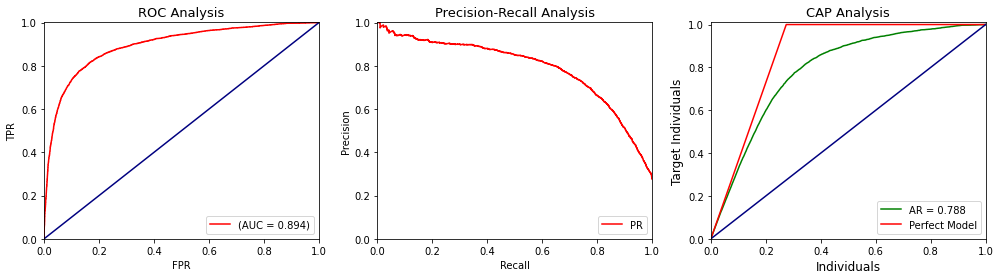

In [78]:
binary_classification_evaluation_plot(
    df_test.loc[:, "responded_customer"],
    df_test.loc[:, "response_probability"]
)

_____

Since we aim to predict which customer will responde to a given promotional offer, our definition of success from the business point of view is **conversion rate**. Therefore, the **lift** of conversion rates when using our model will indicate how successful the project development is so far.

This analysis is going to be carried out not only globally but also for each individual promotional offer.

### 6.1. Overall Conversion Rate

First, let's take a look at the global conversion rate in order to find out whether there is any sort of improvement.

In [79]:
bmk_conversion_rate = df_test.loc[:, "responded_customer"].mean()
print(f"BMK Overall Conversion Rate: {100*bmk_conversion_rate:.2f}%")

BMK Overall Conversion Rate: 27.40%


In [80]:
model_conversion_rate = df_test.loc[(df_test.response_prediction == 1), "responded_customer"].mean()
print(f"Model Overall Conversion Rate: {100*model_conversion_rate:.2f}%")

Model Overall Conversion Rate: 73.34%


In [81]:
lift = model_conversion_rate / bmk_conversion_rate
print(f"Overall lift: {lift:.2f}")

Overall lift: 2.68


### 6.2. Conversion Rate by Promotional Offer

It is also useful to look at a more granular level - by each promotional offer - because it can help us focus on some types of offer in order to leverage the business and increase revenues.

In [82]:
lift_offer = (
    df_test.loc[:, ["offer", "responded_customer"]]
           .groupby("offer")
           .mean()
           .reset_index()
)
model_results = (
    df_test.loc[(df_test.response_prediction == 1), ["offer", "responded_customer"]]
           .groupby("offer")
           .mean()
           .reset_index()
)

lift_offer.loc[:, "model_response"] = model_results.loc[:, "responded_customer"]
lift_offer.loc[:, "lift"] = lift_offer.loc[:, "model_response"] / lift_offer.loc[:, "responded_customer"]
lift_offer.sort_values(by="lift", ascending=False)

,offer,responded_customer,model_response,lift
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.148597,0.751269,5.055750
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.189622,0.756198,3.987924
2,2906b810c7d4411798c6938adc9daaa5,0.189364,0.747788,3.948933
4,4d5c57ea9a6940dd891ad53e9dbe8da0,0.210928,0.730769,3.464551
7,ae264e3637204a6fb9bb56bc8210ddfd,0.220350,0.717579,3.256543
3,3f207df678b143eea3cee63160fa8bed,0.278920,0.758216,2.718396
8,f19421c1d4aa40978ebb69ca19b0e20d,0.272021,0.691729,2.542929
1,2298d6c36e964ae4a3e7e9706d1fb8c2,0.386549,0.744147,1.925105
5,5a8bc65990b245e5a138643cd4eb9837,0.440667,0.751004,1.704245
9,fafdcd668e3743c1bb461111dcafc2a4,0.423995,0.706294,1.665808


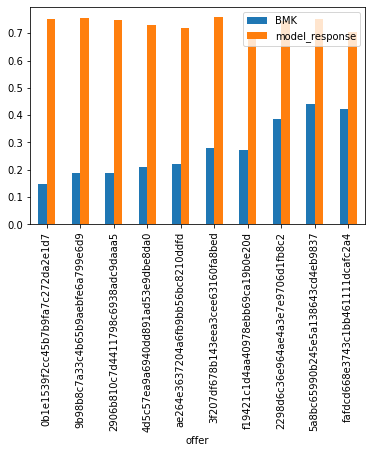

In [83]:
(lift_offer.sort_values(by="lift", ascending=False)
           .iloc[:, :-1]
           .set_index("offer")
           .rename(columns={
               "responded_customer": "BMK",
               "": "model_response"
           })
           .plot(kind="bar")
)

#### Conclusion

From the results presented above, it can be concluded that **the model has intrisic business value**, since it helps us conduct our promotional campaigns in a more targeted way. Not only we are capable of achieving higher conversion rates overall, but we also verify an increase in conversion for every single offer - and the minimum lift value is 1.67 while the maximum is 5.06.

Therefore, by applying the model in order to find out to whom a given promotional offer should be sent we are able to leverage our marketing campaigns and thus achieve higher revenues while incurring less costs with marketing.

## 7. Sending Model to Production

We expect that third-party users will interact with our classification model. Since so far it is only available within SageMaker environment, we can deploy **Lambda functions**.

They will act as an intermediary between users and our model by taking inputs from users and pass those inputs to the deployed endpoint. Then, they get outputs from the deployed endpoint and pass them on to users.

### 7.1. Permission and Security

The first step to achieve our main goal is to give Lambda the right permissions to access SageMaker and our deployed endpoint. Therefore, we create a role for our lambda function and add the following policy: `AmazonSageMakerFullAccess`.

### 7.2. Building and Deploying Lambda Function

Our deployed lambda function looks like this:

```python
import json
import boto3

# Endpoint name of deployed model
ENDPOINT = "sagemaker-scikit-learn-2021-12-16-07-08-18-576"
CLIENT = boto3.client('sagemaker-runtime')

def lambda_handler(event, context):

    # Get event data
    body = event['body']
    data = json.loads(body)["data"]

    # Preparing output
    output = {}
    output["person"] = data["person"]
    output["offer"] = data["offer"]
    output["time_in_days_received"] = data["time_in_days_received"]

    # Make a prediction
    response = CLIENT.invoke_endpoint(
        EndpointName=ENDPOINT,
        Body=json.dumps(data),
        ContentType="application/json"
    )
    response_content = json.loads(response["Body"].read().decode('utf-8'))
    output["response_probability"] = response_content["response_probability"]

    return {
        'statusCode': 200,
        'body': json.dumps(output)
    }
```

### 7.3. Request Example

Our Lambda function was desgined to be **triggered by API requests**. Therefore, it is connected with AWS API Gateway.

The address is the following: `https://0wl6qnnrg9.execute-api.us-east-1.amazonaws.com/default/capstone-project-starbucks`.

In order to request prediction via API, we can execute the following command:

In [84]:
import getpass

api_key = getpass.getpass()
os.environ["API_KEY"] = api_key

········


In [85]:
%%sh

curl -X 'POST' https://0wl6qnnrg9.execute-api.us-east-1.amazonaws.com/default/capstone-project-starbucks \
  -H "x-api-key: ${API_KEY}" \
  -d '{
  "data": {
        "person": "0ea1f0bb1ba245abbf709b962d326dd7",
        "offer": "2906b810c7d4411798c6938adc9daaa5",
        "time_in_days_received": 14.0,
        "responded_customer": 0,
        "gender": "M",
        "age":49.0,
        "income": 89000.0,
        "membership_duration": 818,
        "reward": 2,
        "difficulty": 10,
        "duration": 7,
        "offer_type": "discount",
        "web": 1,
        "email": 1,
        "mobile": 1,
        "social": 0,
        "average_purchase": 30.43,
        "frequency": 1.0
    }
}'

{"person": "0ea1f0bb1ba245abbf709b962d326dd7", "offer": "2906b810c7d4411798c6938adc9daaa5", "time_in_days_received": 14.0, "response_probability": [0.5737565159797668]}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   718  100   168  100   550    170    556 --:--:-- --:--:-- --:--:--   725


## 8. Shutting Endpoint Down

After we have finished our end-to-end project, it is time to shut down the inference endpoint, in order not to incur unnecessary costs.

In [86]:
predictor.delete_endpoint()